# House Price Prediction using Random Forest

## Objective
This project uses the **California Housing Prices** dataset to predict the **median house value** for districts in California.

We analyze relationships between key features such as:

- `median_income`  
- `housing_median_age`  
- geographic location (`longitude`, `latitude`)  
- engineered features (`rooms_per_household`, `bedrooms_per_room`, `population_per_household`)

and build a **Random Forest regression model** to estimate housing prices based on these predictors.


In [88]:
# === Cell 1: Upload dataset from your computer ===
from google.colab import files
import pandas as pd

# Choose the file you downloaded from Kaggle (e.g., california_housing.csv)
uploaded = files.upload()

# Read the uploaded file (it will take the first uploaded filename automatically)
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print("Dataset shape:", df.shape)
df.head()


Saving Data_Before_Cleaning.csv to Data_Before_Cleaning (7).csv
Dataset shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [89]:
# === Cell 2: Data Diagnostics & Cleaning ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("=== DATASET INFO ===")
df.info()

print("\n=== BASIC STATISTICS ===")
print(df.describe(include="all"))

# ---------------------------
# 1. CHECK & FIX MISSING VALUES
# ---------------------------
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

# Fix missing in total_bedrooms (ONLY column with missing data)
if "total_bedrooms" in df.columns:
    median_val = df["total_bedrooms"].median()
    df["total_bedrooms"].fillna(median_val, inplace=True)
    print(f"\nFilled 'total_bedrooms' missing values with median = {median_val}")

print("\nMissing values after filling:")
print(df.isnull().sum())

# ---------------------------
# 2. CHECK DUPLICATES
# ---------------------------
duplicates = df.duplicated().sum()
print(f"\n=== DUPLICATE ROWS: {duplicates} ===")

if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print(f"Duplicate rows removed. New shape: {df.shape}")
else:
    print("No duplicate rows found.")

# ---------------------------
# 3. OUTLIER DETECTION & FIXING (IQR Winsorization)
# ---------------------------
numeric_cols = df.select_dtypes(include=np.number).columns
outlier_counts = {}

print("\n=== FIXING OUTLIERS USING IQR WINSORIZATION ===")

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Count outliers before fixing
    count_before = df[(df[col] < lower) | (df[col] > upper)][col].count()
    outlier_counts[col] = count_before

    # Winsorization (capping extreme values)
    df[col] = np.where(df[col] < lower, lower,
                np.where(df[col] > upper, upper, df[col]))

print("\n=== OUTLIER COUNTS (BEFORE FIXING) ===")
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")

print("\nOutliers have been FIXED using IQR Winsorization (values capped).")

# ---------------------------
print("\n=== DATA CLEANING DONE SUCCESSFULLY ===")


=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

=== BASIC STATISTICS ===
           longitude      latitude  housing_median_age   total_rooms  \
count   20640.000000  20640.000000        20640.000000  20640.000000   
unique           NaN           NaN                 NaN      

/tmp/ipython-input-3604279805.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["total_bedrooms"].fillna(median_val, inplace=True)


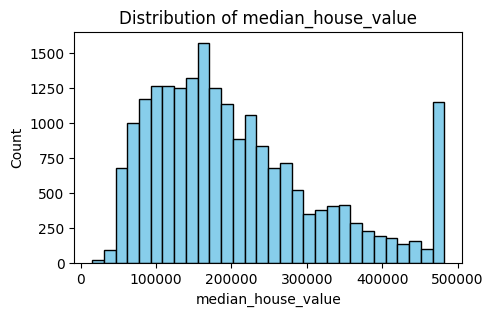

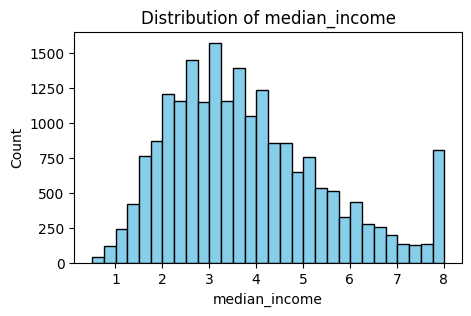

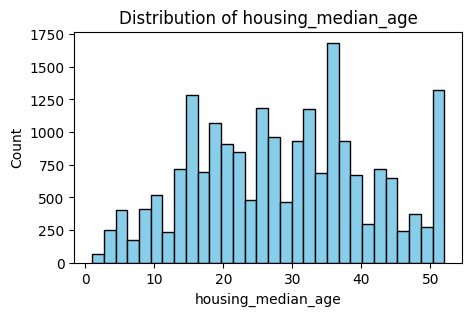

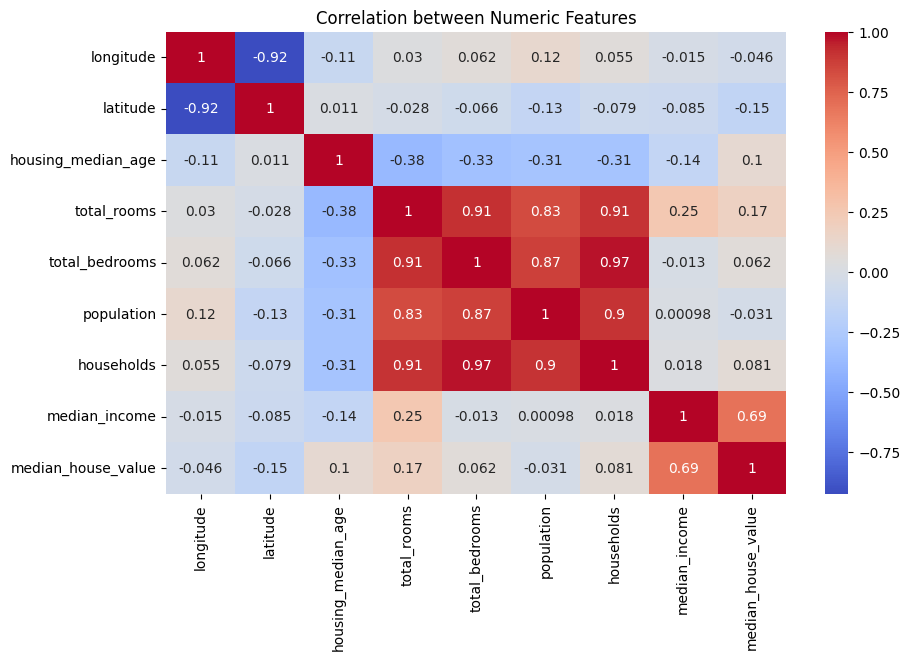

In [90]:
# === Cell 3: Basic visualizations ===
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for main numeric columns
for col in ["median_house_value", "median_income", "housing_median_age"]:
    plt.figure(figsize=(5,3))
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Compute correlation only for numeric columns
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Numeric Features')
plt.show()


In [91]:
# === Cell 3: Prepare features and target ===
from sklearn.model_selection import train_test_split

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

print("Numeric columns:", list(numeric_cols))
print("Categorical columns:", list(cat_cols))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Numeric columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Categorical columns: ['ocean_proximity']


In [94]:
# === 2️⃣ Apply feature engineering AFTER filling NaNs ===
def add_features(df):
    df = df.copy()
    df["rooms_per_household"] = df["total_rooms"] / df["households"]
    df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
    df["population_per_household"] = df["population"] / df["households"]
    return df

X_train = add_features(X_train)
X_test  = add_features(X_test)

# === 3️⃣ Reset indices so they start from 0 ===
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# === 5️⃣ Display first few rows with text headers in Colab ===
from IPython.display import display

print("\n===== First 5 rows of X_train =====")
display(X_train.head())

print("\n===== First 5 rows of X_test =====")
display(X_test.head())



===== First 5 rows of X_train =====


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,NEAR OCEAN,5.017657,0.200576,3.691814
1,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,NEAR OCEAN,4.473545,0.232703,1.738095
2,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,NEAR OCEAN,5.645833,0.174486,2.723214
3,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,NEAR OCEAN,4.002817,0.258269,3.994366
4,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,INLAND,6.268421,0.180940,2.300000



===== First 5 rows of X_test =====


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-119.01,36.06,25.0,1505.0,435.0,1392.0,359.0,1.6812,INLAND,4.192201,0.289037,3.877437
1,-119.46,35.14,30.0,2943.0,435.0,1565.0,584.0,2.5313,INLAND,5.039384,0.147808,2.679795
2,-122.44,37.80,52.0,3830.0,435.0,1310.0,963.0,3.4801,NEAR BAY,3.977155,0.113577,1.360332
3,-118.72,34.28,17.0,3051.0,435.0,1705.0,495.0,5.7376,<1H OCEAN,6.163636,0.142576,3.444444
4,-121.93,36.62,34.0,2351.0,435.0,1063.0,428.0,3.7250,NEAR OCEAN,5.492991,0.185028,2.483645


In [96]:
# === Cell 5: Build a Random Forest Regression model ===
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# Numeric & categorical preprocessing
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())   # Scaling is optional for tree models but allowed
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, cat_cols)
])

# 🟩 Replace LinearRegression() with RandomForestRegressor()
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        max_depth=None,
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)
print("🌲✅ Random Forest model trained successfully!")


🌲✅ Random Forest model trained successfully!


RMSE: 47671.54
R² Score: 0.8203


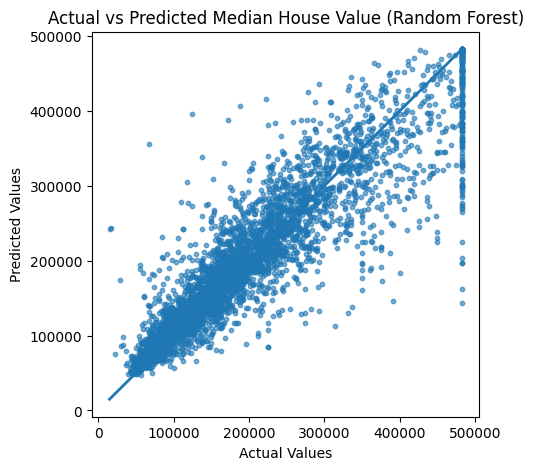

In [97]:
# === Cell 6: Evaluate performance ===
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=10, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Median House Value (Random Forest)")
plt.show()


In [98]:
# ---Save the cleaned data to CSV file ---
cleaned_filename = "california_housing_cleaned.csv"
df.to_csv(cleaned_filename, index=False)
print("✅ Cleaned data saved as:", cleaned_filename)

# --- Step 2: Download it to your local machine ---
from google.colab import files
files.download(cleaned_filename)


✅ Cleaned data saved as: california_housing_cleaned.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [99]:
# === Save combined TRAIN and TEST datasets ===
import pandas as pd
from google.colab import files

# Combine features and target
train_df = X_train.copy()
train_df["median_house_value"] = y_train

test_df = X_test.copy()
test_df["median_house_value"] = y_test

# Save as CSV
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

print("Train/Test files saved.")

# Download the files
files.download("train_data.csv")
files.download("test_data.csv")


Train/Test files saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Conclusion**

The Random Forest regression model achieved an **R² score of approximately 0.82**, indicating that the model explains **82% of the variation** in housing prices.  
The **RMSE of ~48,000** shows that predictions are reasonably close to actual values for this dataset.

---

## **Most Influential Predictors**

- **Median income** — the strongest determinant of house value  
- **Geographic location** (latitude and longitude) — significant spatial effect  
- **Engineered features**, including:
  - rooms_per_household  
  - bedrooms_per_room  
  - population_per_household  

These patterns reflect real housing dynamics: wealthier neighborhoods and desirable geographic zones (e.g., coastal) correlate with higher property values.

---

## **Model Strengths**

- Captures **nonlinear relationships** automatically  
- Handles **feature interactions** without manual work  
- More **robust to outliers** (especially after IQR winsorization)  
- Works well with **numeric and categorical** variables  

---

## **Model Limitations**

- Less interpretable than simpler models  
- Computationally heavier  
- Can struggle with **extrapolation** (predicting outside the training range)

---

## **Possible Improvements**

- Apply **hyperparameter tuning** (GridSearchCV or RandomizedSearchCV)  
- Try **gradient boosting models** (XGBoost, LightGBM, CatBoost)  
- Use **cross-validation** for more reliable performance estimates  
- Add **advanced feature engineering** (spatial clustering, polynomial interactions)

---
